In [1]:
%load_ext autoreload
%autoreload 2

# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
import seaborn as sns

import scipy.io as io
import re
from scipy.signal import resample as scipy_resample
from functools import partial
from tqdm import tqdm
from typing import Callable

from py_ephys.diagnostics import *
from py_ephys.utils import *
import py_ephys.features as ef
from smartseq3.utils import *
from smartseq3.ephys_utils import (
    import_mats,
    get_regex_filter,
    get_std_signal_filter,
    unzip_data_df,
)

import jupyter_black

jupyter_black.load()

ROOT = "data/"
PATH_batch1 = ROOT + "ephys_batch1/Ephys Mat Data"
PATH_batch2 = ROOT + "ephys_batch2/Ephys Mat Data"

In [89]:
# TODO: Make compatible with EphysCellFeatureExtractor
# this might need a wrapper so dc can be passed as a parameter among other things.
# TODO: Check how to deal with clipped features and loc vs iloc!
# TODO: Add diagnostic plotting functions [x]
#       - spike ft diagnostics [x]
#       - sweep ft diagnostics [x]
#       - sweepset ft diagnostics [x]
#       - convenience function to plot diagnostic summary for sweep / sweepset [x]
# TODO: Check carefully if features make sense for a few examples
# TODO: Crosscheck with old pipeline b4 adding it to .py and merging into main
# TODO: blacken code [x]
# TODO: Add feature dependencies to function descriptions [x] (? make compound features that automatically satisfy dependencies! (or try to calculate them in the get_feature function))
# TODO: Add docstring parsing for feature descriptions ! [x]
# TODO: Add documentation [x]
# TODO: Clean up code [x]
# TODO: Add spike rate feature since stimulus intervals are different and spike count is not reliable [x]
# TODO: make feature names consistent, i.e. num_spikes vs spike_count [x]
# TODO: Add unit tests! [x]
# TODO: Fix tests for sag and time constant! [x]
# TODO: restructure code -> smartseq3 module + tests + notebooks [x]
# includes analysis.py, utils.py, morpho.py, ephys.py, AllenSDK (ephys_extractor.py, ephys_features.py)

In [135]:
## PIPELINE
from smartseq3.ephys_utils import filter_df, preprocess_fp_data

fpaths = [os.path.join(PATH_batch1, f) for f in os.listdir(PATH_batch1) if ".mat" in f]

# pre-filter fpaths
metadata_batch1 = pd.read_excel(
    ROOT + "/ephys_batch1/cell_metadata_batch1.xlsx", dtype={"fp_rm_sweep": str}
)

bad_cells = metadata_batch1["cell"][~metadata_batch1["delete"].isna()].to_list()
fpaths = [p for p in fpaths if not any([(cell in p) for cell in bad_cells])]

old_cells = metadata_batch1["cell"][metadata_batch1["Subgroup"] == "Old"].to_list()
fpaths = [p for p in fpaths if not any([(cell in p) for cell in old_cells])]

## IMPORT DATA
data = import_mats(fpaths[:100])

## PREPROCESS FP DATA
fp_data = filter_df(data, get_regex_filter("label", "fp"))
fp_data = preprocess_fp_data(fp_data, metadata_batch1, filt_cutoff=2)

rescaling: 100%|██████████| 335/335 [00:01<00:00, 227.31it/s]


In [150]:
### Extract features from data
index = 43  # 2, 11, 18
ts, Uts, Its = unzip_data_df(fp_data, index, "array")
dc = fp_data["dc"].iloc[index]
ts = ts / 1000
start, end = np.stack(
    [
        np.round(t[I != 0][[0, -1]]) if any(I != 0) else np.stack([np.nan, np.nan])
        for t, I in zip(ts, Its)
    ]
).T
fp_sweepset = EphysSweepSetFeatureExtractor(ts, Uts, Its, filter=2, dc_offset=dc)
fp_sweepset.set_stimulus_amplitude_calculator(ef.get_sweep_stim_amp)

for ft, ft_func in ef.get_available_spike_features().items():
    fp_sweepset.add_spike_feature(ft, ft_func)

for ft, ft_func in ef.get_available_sweep_features(True).items():
    fp_sweepset.add_sweep_feature(ft, ft_func)

for ft, ft_func in ef.get_available_sweepset_features(True).items():
    fp_sweepset.add_sweepset_feature(ft, ft_func)

fp_sweepset.process()

/home/jnsbck/Uni/PhD/projects/smartseq3/py_ephys/allen_sdk/ephys_features.py:1025: RuntimeWarning: Mean of empty slice.
  return v[start_index:end_index].mean()
/home/jnsbck/Applications/anaconda3/envs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jnsbck/Applications/anaconda3/envs/ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jnsbck/Applications/anaconda3/envs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/jnsbck/Applications/anaconda3/envs/ml/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/jnsbck/Uni/PhD/projects/smartseq3/py_ephys/diagnostics.py:1597: UserWarning: r_input sweepset plotting is not yet implemented yet!
  if not np.isnan(ft["value"]):


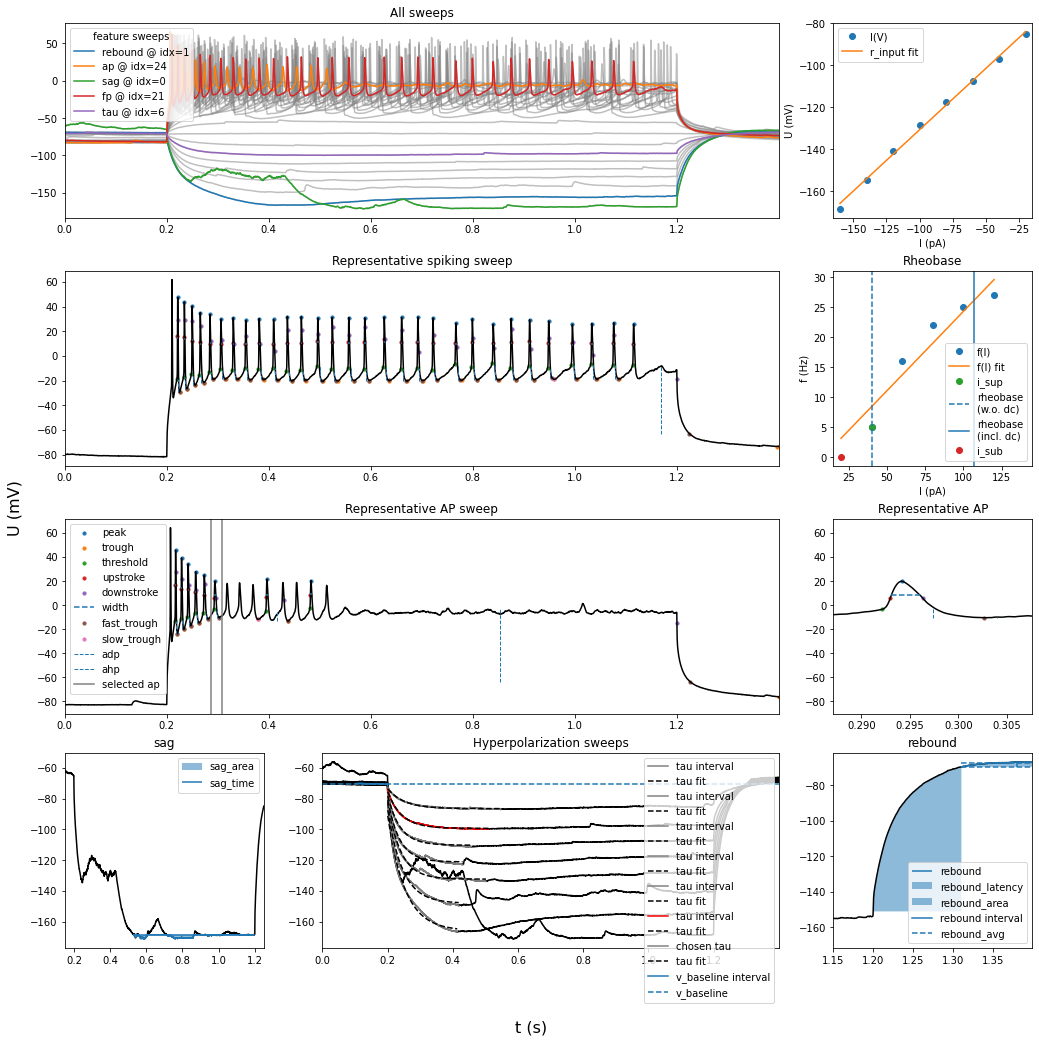

In [134]:
fig, axes = plot_sweepset_diagnostics(fp_sweepset)
# FIX SAG, AP features (width, ADP, AHP)
plt.show()

In [60]:
# list_of_arrays = lambda xs: [x for x in xs]
# ramps_sweepset = efex.EphysSweepSetFeatureExtractor()
# short_squares_sweepset = efex.EphysSweepSetFeatureExtractor()
# long_squares_sweepset = efex.EphysSweepSetFeatureExtractor(
#     list_of_arrays(ts),
#     list_of_arrays(Uts),
#     list_of_arrays(Its),
#     filter=1,
#     start=0.1,
#     end=0.7,
# )
# cell = efex.EphysCellFeatureExtractor(
#     ramps_sweepset, short_squares_sweepset, long_squares_sweepset
# )

In [70]:
# cell.process("long_squares")  # needs to be run before spikes
# cell.process("long_squares_spiking")


/home/jnsbck/Uni/PhD/projects/smartseq3/smartseq3/ephys_extractor.py:1290: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, v)[0]


In [153]:
# cell.long_squares_features("spiking").sweep_features("avg_rate")

In [68]:
# ft_df = fp_sweepset.get_sweep_features()  # .applymap(strip_info)
# sweepset_fts = {
#     ft: ft_func(ft_df) for ft, ft_func in ef.get_fp_sweepset_ft_dict().items()
# }
# sweepset_fts

In [162]:
# idea for new API

from abc import ABC, abstractmethod

class EphysFeature(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def __call__(self, sweep):
        pass

    @abstractmethod
    def plot(self, sweep):
        pass


class SweepNumAPs(EphysFeature):
    def __init__(self):
        super().__init__()

    def __call__(self, sweep):
        pass

    def plot(self, sweep):
        pass


{"num_ap": SweepNumAPs()}